Base

In [1]:
# 文件名：Comparison_Euler_vs_Milstein.ipynb

# 导入所需的库和模块
import numpy as np
import matplotlib.pyplot as plt
from EulerScheme import EulerScheme
from MilsteinScheme import MilsteinScheme
from HestonModel import HestonModel
from MonteCarloSimulator import MonteCarloSimulator
from OptionPricer import OptionPricer
from MethodComparison import MethodComparison

# 初始化Heston模型的参数
S0 = 100        # 初始资产价格
v0 = 0.04       # 初始波动率
kappa = 2.0     # 均值回复速率
theta = 0.04    # 长期均值
sigma = 0.3     # 波动率的波动率
rho = -0.7      # 相关性
r = 0.05        # 无风险利率
T = 1           # 到期时间
K = 100         # 期权执行价格
true_price = 10  # 用于比较的真实期权价格（可以是估计的或理论计算的）

# 定义模拟参数
num_paths = 100     # 模拟路径数
num_steps = 100       # 时间步数

# 创建Heston模型实例
heston_model = HestonModel(S0, v0, kappa, theta, sigma, rho, r)

# 创建Euler和Milstein离散化方案
euler_scheme = EulerScheme(S0, v0, kappa, theta, sigma, rho, r)
milstein_scheme = MilsteinScheme(S0, v0, kappa, theta, sigma, rho, r)

# 使用MethodComparison类比较两种方案的精度
comparison = MethodComparison(heston_model, T, K, true_price)

IndentationError: unexpected indent (MonteCarloSimulator.py, line 20)

Euler Scheme Accuracy (Error): 2.170540205483059
Milstein Scheme Accuracy (Error): 0.8385657643321256


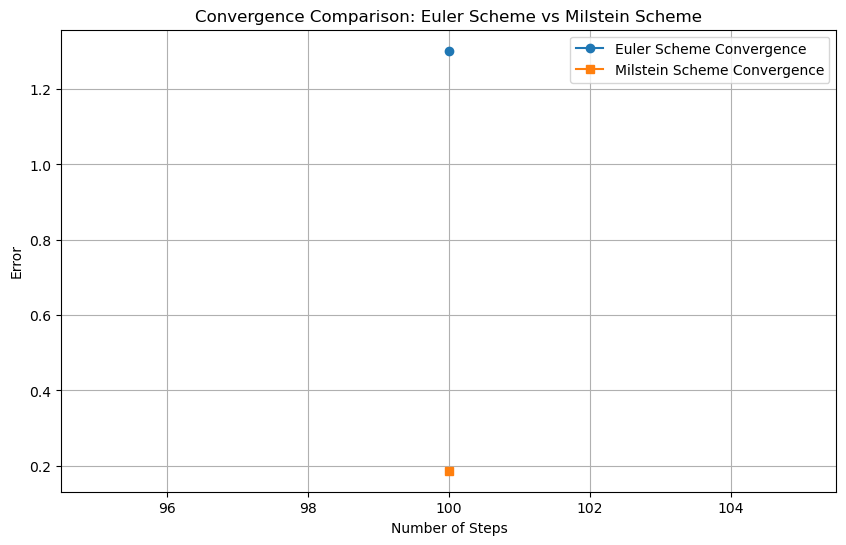

Euler Scheme Stability (Standard Deviation): 0.5872102528147769
Milstein Scheme Stability (Standard Deviation): 0.2416518077068046


In [2]:

# 计算两种方案的误差（偏离真实价格）
euler_accuracy = comparison.accuracy(euler_scheme, num_paths, num_steps)
milstein_accuracy = comparison.accuracy(milstein_scheme, num_paths, num_steps)

print(f"Euler Scheme Accuracy (Error): {euler_accuracy}")
print(f"Milstein Scheme Accuracy (Error): {milstein_accuracy}")

# 比较两种方案的收敛性
step_sizes = [100]  # 不同的时间步数
euler_convergence = comparison.convergence(euler_scheme, num_paths, step_sizes)
milstein_convergence = comparison.convergence(milstein_scheme, num_paths, step_sizes)

# 绘制收敛性比较图
plt.figure(figsize=(10, 6))
plt.plot(step_sizes, euler_convergence, label='Euler Scheme Convergence', marker='o')
plt.plot(step_sizes, milstein_convergence, label='Milstein Scheme Convergence', marker='s')
plt.xlabel('Number of Steps')
plt.ylabel('Error')
plt.title('Convergence Comparison: Euler Scheme vs Milstein Scheme')
plt.legend()
plt.grid(True)
plt.show()

# 比较两种方案的稳定性
num_trials = 2
euler_stability = comparison.stability(euler_scheme, num_paths, num_steps, num_trials)
milstein_stability = comparison.stability(milstein_scheme, num_paths, num_steps, num_trials)

print(f"Euler Scheme Stability (Standard Deviation): {euler_stability}")
print(f"Milstein Scheme Stability (Standard Deviation): {milstein_stability}")